# Example: Simulation of American Option Price Dynamics using a Binomial Lattice
This example will familiarize students with the simulation of the price dynamics of [American-style option contracts](https://en.wikipedia.org/wiki/Option_style). In particular, we'll explore how the contract length, i.e., the days to expiration (DTE), influences the contract price as a function of the strike price $K$.

### Learning Tasks
* `Prerequisites`: load and interrogate the options chains for different values of the days to expiration (DTE) parameter for an example underlying ticker, in this case, [Advanced Micro Devices](https://finance.yahoo.com/quote/AMD/) with the ticker symbol `AMD.`
* __Task 1__: Visualize the premium trends in an `AMD` options dataset
* __Task 2__: Estimate the Implied Volatility `IV` of `AMD` options from the `AMD` pricing dataset.
    * `Check`: Test the `IV` estimation calculation for an `MU` put option (does our code work?)
    * `Check`: Test the `IV` calculation for an `NVDA` call option
    * `Check`: AMD contract premium calculation using the estimated `IV`

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-1/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-1`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-1/Manifest.toml`


## Prerequisites
Before doing anything else, load the options chain dataset using the `MyOptionsChainDataSet()` function. This function returns the pricing data as a [Julia Dictionary type](https://docs.julialang.org/en/v1/base/collections/#Dictionaries) with `keys` holding the number of days to expiration `DTE::Int64` and `values` being a [Vector](https://docs.julialang.org/en/v1/base/arrays/#Base.Vector-Tuple{UndefInitializer,%20Any}) of multilevel dictionaries. We'll store the options contract price data in the `dataset` variable.
* In this example, we'll use options pricing data for [Advanced Micro Devices](https://finance.yahoo.com/quote/AMD/) as the underlying asset. The `dataset` variable holds pricing information for `call` and `put` contracts. Each contract has a different strike price. In addition to the contract price, there is additional information about the underlying asset and contract. 
* For any given `DTE` key, the price data is organized as a `Vector{Dict{String, Any}},` where each element in the vector corresponds to a different strike price, and each strike price is a dictionary with keys: `day,` `details,` `last_quote,` `last_trade,` `underlying_asset,` `open_interest` and `break_even_price.` Each key (except for the `open_interest` and `break_even_price` keys) points to another dictionary.

In [5]:
dataset = MyOptionsChainDataSet()

Dict{Int64, Vector{Dict{String, Any}}} with 14 entries:
  123 => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>79.1, "change_perc…
  60  => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>73, "change_percen…
  32  => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>76.7, "change_perc…
  11  => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>59.05, "change_per…
  368 => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>81.1, "change_perc…
  578 => [Dict("day"=>Dict{String, Any}(), "details"=>Dict{String, Any}("contra…
  732 => [Dict("day"=>Dict{String, Any}(), "details"=>Dict{String, Any}("contra…
  39  => [Dict("day"=>Dict{String, Any}(), "details"=>Dict{String, Any}("contra…
  914 => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>81.5, "change_perc…
  25  => [Dict("day"=>Dict{String, Any}(), "details"=>Dict{String, Any}("contra…
  151 => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>74.25, "change_per…
  4   => [Dict("day"=>Dict{String, Any}(), "details"=

For example, we can access the first contract with `DTE = 39 days` to expiration, which corresponds to a `K = 185 USD/share` strike price, by first passing in the `DTE` key value, followed by the index `1`, i.e., `dataset[39][1]`:

In [7]:
dataset[39][1]

Dict{String, Any} with 8 entries:
  "day"              => Dict{String, Any}()
  "details"          => Dict{String, Any}("contract_type"=>"put", "ticker"=>"O:…
  "last_quote"       => Dict{String, Any}("midpoint"=>64.175, "ask"=>65.65, "ti…
  "last_trade"       => Dict{String, Any}()
  "underlying_asset" => Dict{String, Any}("timeframe"=>"REAL-TIME", "ticker"=>"…
  "greeks"           => Dict{String, Any}()
  "open_interest"    => 0
  "break_even_price" => 120.825

__Details__: To access the `details` field for the `(DTE, index) = (39,1)` contract (which corresponds to a `put` contract with a strike price of `K = 185.0` USD/share, we can append the `details` key (or any other of the sub-keys) to the end of the dataset call, i.e., `dataset[39][1]["details"]`:

In [9]:
dataset[39][1]["details"]

Dict{String, Any} with 6 entries:
  "contract_type"       => "put"
  "ticker"              => "O:AMD230728P00185000"
  "strike_price"        => 185
  "exercise_style"      => "american"
  "expiration_date"     => "2023-07-28"
  "shares_per_contract" => 100

__Quote__: To access the `last_quote` field for the `(DTE, index) = (39,1)` contract (which corresponds to a `put` contract with a strike price of `K = 185.0` USD/share), we can append the `last_quote` key (or any other of the sub-keys) to the end of the dataset call, i.e., `dataset[39][1]["last_quote"]`:

In [11]:
dataset[39][1]["last_quote"]

Dict{String, Any} with 7 entries:
  "midpoint"     => 64.175
  "ask"          => 65.65
  "timeframe"    => "REAL-TIME"
  "bid_size"     => 10
  "ask_size"     => 1
  "bid"          => 62.7
  "last_updated" => 1686945598063236608

__Underlying__: To access the `underlying_asset` field for the `(DTE, index) = (39,1)` contract (which corresponds to a `put` contract with a strike price of `K = 185.0` USD/share), we can append the `underlying_asset` key (or any other of the sub-keys) to the end of the dataset call, i.e., `dataset[39][1]["underlying_asset"]`:

In [13]:
dataset[39][1]["underlying_asset"]

Dict{String, Any} with 5 entries:
  "timeframe"            => "REAL-TIME"
  "ticker"               => "AMD"
  "price"                => 119.62
  "change_to_break_even" => 1.205
  "last_updated"         => 1686959999095781050

Finally, get the price of the underlying asset at the time when the options quote data was recorded. Save this value in the `Sₒ` variable. The value of `Sₒ` should be the same for all option expirations, so we pick a typical day, e.g., `DTE = 39 days`.

In [15]:
Sₒ = dataset[39][1]["underlying_asset"]["price"]

119.62

## Task 1: Visualize the price trends in the `AMD` options dataset
Let's look at the price of `call` or `put` options on `AMD` as the ratio of the current price to the strike price $K/S_{\circ}$ and the expiration dates change. 
* First, we initialize storage in the `list_of_options_chains::Dict{Int64, DataFrame}` variable. This dictionary, whose keys correspond to `DTE` values that point to a `DataFrame` (exported from the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl)), holds information about an option in `dataset` that meets the criteria specified in the `search(...)` function. In this case, we are looking at `put` contracts whose strike price is between `60` and `180` USD/share.
* We iterate through each day to expiration `DTE` value in the options `dataset,` capture all the records that meet the search criteria, and store them in the `list_of_options_chains::Dict{Int64, DataFrame}` variable.

In [17]:
list_of_options_chains = Dict{Int64,DataFrame}();
DTEs = keys(dataset) |> collect |> sort;
for dte_value ∈ DTEs

    dataframe = search(dataset, dte_value, (DTE::Int64, record::Dict{String, Any}) -> begin

            # initialize -
            should_keep_record = false;

            # what is the strike?
            K = record["details"]["strike_price"];
            if (record["details"]["contract_type"] == "put" && 60.0 ≤ K ≤ 180.0)
                should_keep_record = true
            end;
            
            # return -
            return should_keep_record;
        end
    );
    list_of_options_chains[dte_value] = dataframe;
end

`Unhide` the code block below to see how we plotted the `midpoint` price for the `AMD` options contract for different days to expiration (DTE) and strike price $K$ values, and constant current price $S_{\circ}$ values.

__Summary__: The `blue` curve denotes the `midpoint` price as a function of the strike price for `AMD` put contracts with `DTE = 4 days` to expiration. On the other hand, the `orange` curve denotes the `midpoint` price as a function of the strike price for `AMD` put contracts with `DTE = 914 days` to expiration. The light `gray` lines denote `DTE` values between `4` and `914` days.
* As $K/S_{\circ}\rightarrow{0}$, the strike price $K\ll{S}_{\circ}$ is small relative to the current market price $S_{\circ}$, and the premium of the `put` option goes to zero $\mathcal{P}_{p}\rightarrow{0}$. This trend is more pronounced for options with short expirations, with the long-dated options being more expensive. In this regime, the _current_ payoff of the put contract $\max\left(0, K-S_{\circ}\right) = 0$. Thus, the market believes the probability that the share price will fall below the strike before the expiration of the contract is small, and the premium buyers are willing to pay for the contract is small.
* As $K/S_{\circ}\rightarrow\infty$, the premium of the `put` option $\mathcal{P}_{p}\rightarrow\infty$, and the difference between the short- and long-dated options is less pronounced, with the long-dated option being more expensive. In this regime, the _current_ payoff of the put contract $\max\left(0, K-S_{\circ}\right) > 0$. Thus, buyers are willing to pay an increasing premium for contracts in this regime because they have a high probability of receiving a non-zero payoff at expiration.
* In both regimes, the long-dated contracts are always more expensive. In the project for this module, we explore this observation further using the concepts of an options contract's `intrinsic` and `extrinsic` value.

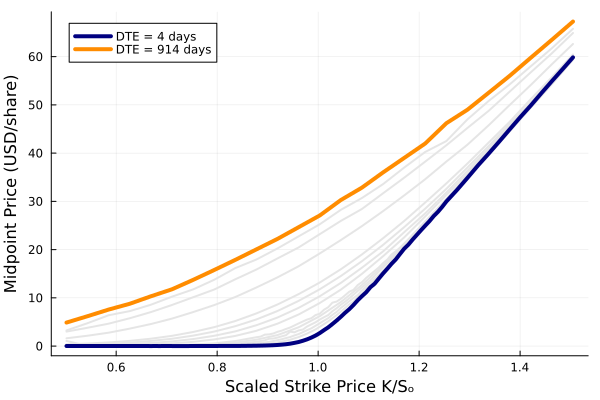

In [19]:
let
    p = plot();
    for dte_value ∈ DTEs
        dataframe = list_of_options_chains[dte_value];
        plot!(dataframe[:,:strike]/Sₒ, dataframe[:,:midpoint], label="", lw=2, c = :gray90);
    end
    current()
    plot!(list_of_options_chains[4][:,:strike]/Sₒ, list_of_options_chains[4][:,:midpoint],
        lw=4, label="DTE = 4 days", c=:navyblue)
    plot!(list_of_options_chains[914][:,:strike]/Sₒ, list_of_options_chains[914][:,:midpoint],
        lw=4, label="DTE = 914 days", c=:darkorange)
    xlabel!("Scaled Strike Price K/Sₒ", fontsize = 18)
    ylabel!("Midpoint Price (USD/share)", fontsize = 18)
end

## Task 2: Estimate the Expected Implied Volatility `IV` from the `AMD` pricing data
Implied volatility `IV` is the market's prediction of the future volatility of the underlying asset's price. It is a crucial factor in option pricing models and is calculated from the current market prices of options contracts rather than being directly observed. Let's use data to compute the unknown implied volatility values for `AMD` options in our `dataset.` However, before estimating the unknown `AMD` implied volatility values, we verify our [estimate_implied_volatility(...) function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.estimate_implied_volatility) implementation on contracts with known `IV` values (to make sure it is working correctly).
* `Checks`: Let's estimate the implied volatility for a `put` option with `DTE = 62 days` on [Micron Technology](https://finance.yahoo.com/quote/MU/), which has the ticker symbol `MU,` and a `call` option on [NVIDIA](https://www.nvidia.com/en-us/) with `DTE = 29 days`. In both cases, we'll compare the estimated expected implied volatility and the observed implied volatility using the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert)
* Once we have verified the [estimate_implied_volatility(...) function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.estimate_implied_volatility) implementation, we'll calculate the expected implied volatility of `AMD` options in the `dataset` that have the same strike price `K,` but different expiration dates.

### Check: Test the IV calculation for an `MU` put option
The test `put` contract has a strike price of `K = 75` USD/share and has `T = 62 days` to expiration. The current share price of `MU` is $S_{o}$ = `79.50 USD/share`, and the risk-free-rate is `r̄ = 4.9%`. The midpoint premium for this contract is $\mathcal{P}_{p}$ = `2.93` USD/share, and the implied volatility `IV = 0.4005`.

In [22]:
r̄ = 0.049; # risk free rate
Δt = (1/365); # step-size, assuming 365-trading days per year
T = 62*Δt; # duration of the contract (units: years)
IV = 0.4005; # implied volatility - we are estimating this
Sₒ = 79.50; # share price at contract purchase (units: USD/share)
K = 75.0; # strike price for the MU contract (units: USD/share)
h = 124; # number of levels in the binomial tree
𝒫 = 2.93; # contract premium (midpoint)

To begin, create an instance of the [MyAmericanPutContractModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel), which holds the data for the contract information using a specialized [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanPutContractModel},%20NamedTuple}). We store this instance in the `test_american_put_contract_model` variable. To construct a [MyAmericanPutContractModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) instance, we pass contract parameters to the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanPutContractModel},%20NamedTuple}), where the `IV` value is a placeholder guess (we update this value below):

In [24]:
test_american_put_contract_model = build(MyAmericanPutContractModel, (
        K = K, sense = 1, copy = 1, DTE = T, IV = 0.1, premium = 𝒫));

Next, let's estimate the implied volatility using the [estimate_implied_volatility(...) function]((https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.estimate_implied_volatility). This function takes a contract model and parameters associated with the options price, namely, the current share price of the underlying asset `Sₒ,` the number of levels in the tree `h,` and the risk-free rate `r̄.` It returns a [Tuple](https://docs.julialang.org/en/v1/manual/functions/#Tuples), holding the likelihood of a volatility value and the implied volatility estimate.
* The [estimate_implied_volatility(...) function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.estimate_implied_volatility) requires an initial guess for the implied volatility `IV.` We simulate a range of potential initial values to account for uncertainty in the value. The resulting estimates and their likelihoods are stored in the `test_data` array. We then calculate the expected value of the `IV` using the likelihood scores.

In [26]:
initial_guess_vector = range(0.2,stop=0.6,length=5) |> collect;
test_data = Array{Float64,2}(undef, length(initial_guess_vector), 2); # holds the estimated likelihood and IV values
for i ∈ eachindex(initial_guess_vector)
   
    test_american_put_contract_model.IV = initial_guess_vector[i]; # update the IV value on the model with our guess
    result = estimate_implied_volatility(test_american_put_contract_model, Sₒ = Sₒ, h = h, r̄ = r̄);
    test_data[i,1] = result[1];
    test_data[i,2] = result[2];
end
Z = sum(test_data[:,1]);
IV_computed = dot((1/Z)*test_data[:,1],test_data[:,2]) # expected value
println("The computed expected implied volatility: $(IV_computed)")

The computed expected implied volatility: 0.4009459877014182


Finally, we compare the estimated and observed `IV` values using the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) in combination with the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox). If the values differ by more than a specified tolerance (in this case, `atol = 1e-3`), then an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown:

In [28]:
@assert isapprox(IV_computed,IV,atol = 1e-3);

### Check: Test the IV calculation for an `NVDA` call option
The `call` contract for `NVDA` has a strike price of `K = 1,130 USD/share` and `DTE = 29 days` until expiration. The current share price of `NVDA` is $S_{\circ}$ = `1,122.13 USD/share`, and the risk-free rate is `4.9%`. The bid-side premium is `56.10 USD/share`, and the ask-side premium is `57.45 USD/share`. The published implied volatility is `0.4622`.

In [30]:
r̄ = 0.049; # risk free rate
Δt = (1/365); # step-size, assuming 365-trading days per year
T = 29*Δt; # duration of the contract (units: years)
IV = 0.4622; # implied volatility - we are estimating this
Sₒ = 1122.13; # share price at contract purchase (units: USD/share)
K = 1130; # strike price for the MU contract (units: USD/share)
h = 124; # number of levels in the binomial tree
𝒫 = (56.10+57.45)/2; # contract premium (midpoint)

First, we create an instance of the [MyAmericanCallContractModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanCallContractModel), which holds the data for the contract information using a specialized [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanCallContractModel},%20NamedTuple}). We store this instance in the `test_american_call_contract_model` variable:

In [32]:
test_american_call_contract_model = build(MyAmericanCallContractModel, (
        K = K, sense = 1, copy = 1, DTE = T, IV = 0.1, premium = 𝒫));

Next, like the previous case, we calculate the expected implied volatility, starting from many initial guesses, using the [estimate_implied_volatility(...) function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.estimate_implied_volatility). `Unhide` the code block below to revisit the calculation of the expected implied volatility:

In [34]:
initial_guess_vector = range(0.2,stop=0.7,length=9) |> collect;
test_data = Array{Float64,2}(undef, length(initial_guess_vector), 2); # holds the estimated likelihood and IV values
for i ∈ eachindex(initial_guess_vector)
    test_american_call_contract_model.IV = initial_guess_vector[i]; # update the IV value on the model with our guess
    result = estimate_implied_volatility(test_american_call_contract_model, Sₒ = Sₒ, h = h, r̄ = r̄);
    test_data[i,1] = result[1];
    test_data[i,2] = result[2];
end
Z = sum(test_data[:,1]);
IV_computed = dot((1/Z)*test_data[:,1],test_data[:,2]) # expected value
println("The computed expected implied volatility: $(IV_computed)")

The computed expected implied volatility: 0.46257999015225915


Finally, we compare the estimated and observed `IV` values using the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) in combination with the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox). If the values differ by more than a specified tolerance (in this case, `atol = 1e-3`), then an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown:

In [36]:
@assert isapprox(IV_computed,IV, atol = 1e-3);

### Compute the implied volatility of `AMD` contracts as a function of the days to expiration
Now that we have tested our implied volatility `IV` estimation implementation, let's estimate the implied volatility for `AMD` options in our dataset. First, specify a strike price (in the `K̂` variable) you want (the available strike prices can be found in the `details` fields of the `dataset` dictionary):

In [38]:
K̂ = 140; # specify a value

Next, find the records in `dataset` for strike price `K̂` with days to expiration of less than `DTE = 120 days` using the `search(...)` function. Note: this `DTE` cutoff is arbitrary; you can choose a different value. The code block below iterates through all the `DTE` values in the `dataset` using a `for-loop.` During each iteration of the loop, we check if the strike price and expiration conditions are satisfied. If so, we store the data record in the `list_of_AMD_contracts::Dict{Int64, DataFrame}` collection.
* The `list_of_AMD_contracts::Dict{Int64, DataFrame}` collection has keys corresponding to `DTE` values which point to [DataFrame instances](https://dataframes.juliadata.org/stable/) holding the contract data. Each [DataFrame](https://dataframes.juliadata.org/stable/) has the fields: `underlying,` `strike,` `type,` `bid,` `ask,` `midpoint,` `bid_size` and `ask_size.`

In [40]:
list_of_AMD_contracts = Dict{Int64,DataFrame}();
DTEs = keys(dataset) |> collect |> sort;
for dte_value ∈ DTEs
    dataframe = search(dataset, dte_value, (DTE::Int64, record::Dict{String, Any}) -> begin

            # initialize -
            should_keep_record = false;
            K = record["details"]["strike_price"]; # get the strike price from the record
            if (record["details"]["contract_type"] == "put" && (K == K̂) && DTE < 120)
                should_keep_record = true
            end;
            
            # return -
            return should_keep_record;
        end
    );

    if (nrow(dataframe) != 0)
        list_of_AMD_contracts[dte_value] = dataframe;
    end
end
list_of_AMD_contracts[4] # example for DTE = 4 option contract

Row,underlying,strike,type,bid,ask,midpoint,bid_size,ask_size
,Float64,Float64,String,Float64,Float64,Float64,Int64,Int64
1,119.62,140.0,put,19.75,20.6,20.175,11,4


Next, we create an instance of the [MyAmericanPutContractModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel), which holds the data for a contract using a specialized [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanPutContractModel},%20NamedTuple}). We store this instance in the `tmp_contract_model` variable. We'll update the fields of `tmp_contract_model` in a loop below, so for now, we use placeholder values for the fields: 

In [42]:
tmp_contract_model = build(MyAmericanPutContractModel, (
        K = K̂, sense = 1, copy = 1, DTE = 914*Δt, IV = 0.49, premium = 27.075)); # we'll update values below

Now that we have the list of contracts with strike $\hat{K}$ as a function of the days to expiration, we can estimate the implied volatility `IV` for each contract. `Unhide` the code block below to see how we compute the implied volatility for different values of the contract's days to expiration `DTE.`
* First, we need to obtain a sorted array of `DTE` values from the keys of the `list_of_AMD_contracts` dictionary. Then, we'll initialize the `IV_results_array` array, which will be used to store the calculation results. The `IV_results_array` will have a length equal to the `DTE_array` and two columns. Each row will hold the results for a different `DTE` value, with the value itself stored in column 1 and the expected implied volatility stored in column 2.
* Next, you will need to process each `DTE` value in the `DTE_array` using a `for-loop.` During each iteration of the loop, you will perform a similar calculation as shown above. This involves creating a contract model, setting data on that model, and estimating the expected value of the implied volatility for each `DTE` value. The data for each pass of the loop will be stored in the `IV_results_array.`
* Finally, we place the contents of the `IV_results_array` into a [DataFrame](https://dataframes.juliadata.org/stable/) and then display them after the calculation is completed.

In [44]:
DTE_array = keys(list_of_AMD_contracts) |> collect |> x-> sort(x,rev=true)
IV_results_array = Array{Float64,2}(undef, length(DTE_array),2);
for i ∈ eachindex(DTE_array)

    record = list_of_AMD_contracts[DTE_array[i]];
    tmp_contract_model.DTE = DTE_array[i]*Δt; # T is the duration of the contract, measured in years
    tmp_contract_model.premium = record[!,:midpoint][1] # observed premium

    # We sample a few initial guesses -
    initial_guess_vector = range(0.2,stop=0.7,length=9) |> collect;
    test_data = Array{Float64,2}(undef, length(initial_guess_vector), 2); # holds the estimated likelihood and IV values
    for j ∈ eachindex(initial_guess_vector)
        
        tmp_contract_model.IV = initial_guess_vector[j]; # update the IV value on the model with our guess
        result = estimate_implied_volatility(tmp_contract_model, Sₒ = record[!,:underlying][1], h = 124, r̄ = r̄);
        test_data[j,1] = result[1];
        test_data[j,2] = result[2];
    end

    IV_results_array[i,1] = DTE_array[i] |> x-> convert(Float64,x);
    IV_results_array[i,2] = sum(test_data[:,1]) |> Z -> dot((1/Z)*test_data[:,1],test_data[:,2]);
end

# build a DataFrame to show the results -
df_IV_results = DataFrame()
for i ∈ eachindex(DTE_array)
    row_df = (
        DTE = IV_results_array[i,1],
        IV = IV_results_array[i,2]
    );
    push!(df_IV_results, row_df);
end
df_IV_results

Row,DTE,IV
,Float64,Float64
1,88.0,0.458275
2,60.0,0.467055
3,39.0,0.439312
4,32.0,0.433274
5,25.0,0.442361
6,18.0,0.370304
7,11.0,0.337825
8,4.0,0.474267


### Check: Contract premium calculation using the estimated `IV`
It's crucial to validate our `IV` estimates, which are derived from the [Cox, Ross, and Rubinstein model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model), as this method can sometimes be prone to convergence issues. This validation uses the `IV` values to recalculate the corresponding option contract premium. To understand this process, `unhide` the code block below to see how we recompute the option premium and how we display the data.
* First, we initialize the `dataframe_check` variable, an empty [DataFrame](https://dataframes.juliadata.org/stable/) to hold the validation data. Next, we use a `for-loop` to process each `DTE` value in `DTE_array.` For each iteration of the loop, we create instances of the [MyAdjacencyBasedCRREquityPriceTree](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAdjacencyBasedCRREquityPriceTree) and [MyAmericanPutContractModel types](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) which hold the price tree, and options contract information for the contract contained in the `record` variable. Finally, we compute the premium using the [premium function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.premium) and store this value in the `computed_premium` variable.
* We display the data by populating the `dataframe_check` variable using the [Julia push!(...) function](https://dataframes.juliadata.org/stable/lib/functions/#Base.push!) one row at a time, where each row corresponds to a `DTE` value. In each row, we show the `DTE` value for the contract, the scaled strike price $K/S_{\circ}$, the estimated `IV,` the bid $\mathcal{P}_{bid}$ and ask $\mathcal{P}_{ask}$ side premiums, the computed premium $\mathcal{P}$, the `bid_size` and `ask_size,` the `inbounds` field reports whether the condition $\mathcal{P}_{bid}\leq\mathcal{P}\leq\mathcal{P}_{ask}$ is `true | false`, and the percentage error between the computed premium $\mathcal{P}$ and the midpoint premium $\mathcal{P}_{mid}=(\mathcal{P}_{bid}+\mathcal{P}_{ask})/2$.
* __Summary__: Most `AMD` contracts have a calculated premium with a percentage error of less than or equal to `~1%`, and the premium value $\mathcal{P}$ falls within the range of the `bid` price $\mathcal{P}_{bid}$ and the `ask` price $\mathcal{P}_{ask}$. However, this may not always hold true for all strike prices in the dataset. Between the two conditions - the percentage error between the calculated premium and the midpoint premium, and the premium falling within the bid-ask range - the latter is more important as the midpoint may not accurately represent the state of the order book at the time of data collection. Lastly, based on anecdotal evidence, we anticipate more errors when $\left(K/S_{\circ}\right)\sim{1}$ as this represents the highest level of uncertainty.

In [46]:
dataframe_check = DataFrame();
for i ∈ eachindex(DTE_array)
    
    record = list_of_AMD_contracts[DTE_array[i]];
    DTE =  DTE_array[i]*Δt;
    IVᵢ = IV_results_array[i,2];
    Sᵢ = record[!,:underlying][1];
    𝒫 = record[!,:midpoint][1];
    bid = record[!,:bid][1];
    bid_size = record[!,:bid_size][1];
    ask = record[!,:ask][1];
    ask_size = record[!,:ask_size][1];
    
    # build tree model -
    treemodel = build(MyAdjacencyBasedCRREquityPriceTree, 
        (μ = r̄, T = DTE, σ = IVᵢ)) |> (x-> populate(x, Sₒ = Sᵢ, h = 256));

    # build contract model -
    tmp_contract_model = build(MyAmericanPutContractModel, (
        K = K̂, sense = 1, copy = 1, DTE = DTE, IV = IVᵢ, premium = 𝒫));

    # compute the premium -
    computed_premium = premium(tmp_contract_model, treemodel, sigdigits = 6);

    # store -
    row_df = (
        DTE = DTE_array[i],
        scaled_strike = K̂/Sᵢ,
        IV = IV_results_array[i,2],
        bid = bid,
        ask = ask,
        computed = computed_premium,
        bid_size = bid_size,
        ask_size = ask_size,
        inbounds = (bid <= computed_premium) && (computed_premium <= ask) ? true : false,
        percentage_error_midpoint = ((𝒫 - computed_premium)/computed_premium) |> abs |> x-> 100*x |> x-> round(x,sigdigits=3)
    );
    push!(dataframe_check,row_df);
end
dataframe_check

Row,DTE,scaled_strike,IV,bid,ask,computed,bid_size,ask_size,inbounds,percentage_error_midpoint
,Int64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Bool,Float64
1,88,1.17037,0.458275,23.35,23.85,23.6105,52,65,true,0.0445
2,60,1.17037,0.467055,22.25,22.8,22.5194,14,78,true,0.0249
3,39,1.17037,0.439312,20.45,22.05,21.2534,57,58,true,0.016
4,32,1.17037,0.433274,20.85,21.35,20.9323,45,47,true,0.801
5,25,1.17037,0.442361,20.25,21.45,20.7302,10,9,true,0.578
6,18,1.17037,0.370304,19.7,21.25,20.3886,1,1,true,0.424
7,11,1.17037,0.337825,19.55,20.5,20.38,1,8,true,1.74
8,4,1.17037,0.474267,19.75,20.6,20.38,11,4,true,1.01


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.